In [23]:
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import groupby
import json
from utils.utils import get_consecutives

import fastf1
import fastf1.plotting

fastf1.Cache.enable_cache('./data')  

In [10]:
YEAR = 2023
RS = 12122023

with open('./data/teams.json', 'r') as file:
    teams = json.load(file)

## Get all laps

In [11]:
def load_all_races(year):
    '''
    load all races for the chosen year. excludes testing
    '''
    
    schedule= fastf1.get_event_schedule(year)[1:]
    allRaces = {}
    for i in schedule['EventName']:
        
        race = fastf1.get_session(year, i, 'R')
        
        race.load(laps=True, telemetry=False, weather=True,messages=False)
        try:
            allRaces[i] = race.laps
        except Exception as e:
            print(f"Failed to load {i}",e)
            pass
    return allRaces 

allRaces = load_all_races(YEAR)


core           INFO 	Loading data for Bahrain Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '14', '55', '44', '18', '63', '77', '10', '23', '22', '2', '20', '21', '27', '24', '4', '31', '16', '81']
core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_d

## Full laps organized



In [12]:
drivers = {}

for k,r in allRaces.items():
    r['LapTime'] = r['LapTime']
    r['NormLapTime'] = r.LapTime/r.LapTime.min()
    for d in r.Driver.unique():
        try:
            drivers[d] = pd.concat([drivers[d], r[r.Driver == d]])
        except Exception as e:
            drivers[d] = r[r.Driver == d]
            


## Methodology

In [13]:
allDrivers = pd.DataFrame(columns=drivers.keys())
for k,v in drivers.items():
    allDrivers[k] = pd.Series(v.LapTime.values)

allDriversNorm = pd.DataFrame(columns=drivers.keys())
at3 = pd.Series()
for k,v in drivers.items():
    allDriversNorm[k] = pd.Series(v.NormLapTime.values)
    if k in ['RIC','LAW','DEV']:
        at3 = at3.append(pd.Series(v.NormLapTime.values))
allDriversNorm['AT3'] = pd.Series(at3.values)

drivers['VER'].sort_values(by='NormLapTime').head(5)

,Time,DriverNumber,LapTime,LapNumber,PitOutTime,PitInTime,Sector1Time,Sector2Time,Sector3Time,Sector1SessionTime,...,Compound,TyreLife,FreshTyre,Stint,LapStartTime,Team,Driver,TrackStatus,IsAccurate,NormLapTime
38,0 days 02:11:36.649000,1,0 days 00:01:34.183000,39.0,NaT,NaT,0 days 00:00:33.720000,0 days 00:00:42.118000,0 days 00:00:18.345000,0 days 02:10:36.186000,...,HARD,2.0,True,3,0 days 02:10:02.466000,Red Bull Racing,VER,1,True,1.0
99,0 days 02:24:11.139000,1,0 days 00:01:31.906000,50.0,NaT,NaT,0 days 00:00:33.543000,0 days 00:00:29.045000,0 days 00:00:29.318000,0 days 02:23:12.776000,...,HARD,32.0,True,2,0 days 02:22:39.233000,Red Bull Racing,VER,1,True,1.0
41,0 days 02:12:14.851000,1,0 days 00:01:30.275000,42.0,NaT,NaT,0 days 00:00:29.078000,0 days 00:00:36.353000,0 days 00:00:24.844000,0 days 02:11:13.654000,...,SOFT,12.0,False,2,0 days 02:10:44.576000,Red Bull Racing,VER,1,True,1.0
70,0 days 02:27:21.083000,1,0 days 00:01:07.012000,71.0,NaT,NaT,0 days 00:00:17.040000,0 days 00:00:29.896000,0 days 00:00:20.076000,0 days 02:26:31.111000,...,SOFT,5.0,False,5,0 days 02:26:14.071000,Red Bull Racing,VER,1,True,1.0
55,0 days 02:28:47.407000,1,0 days 00:01:24.319000,56.0,NaT,NaT,0 days 00:00:30.765000,0 days 00:00:28.669000,0 days 00:00:24.885000,0 days 02:27:53.853000,...,MEDIUM,5.0,True,4,0 days 02:27:23.088000,Red Bull Racing,VER,1,True,1.0


Text(0.5, 1.0, 'NOR vs HAM Normalized Absolute Pace')

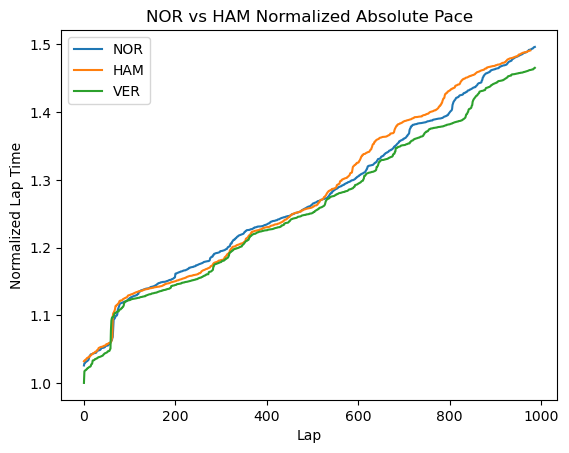

In [14]:
min_time = allDrivers.min().sort_values()[0]
allDrivers_norm = allDrivers.copy()
allDrivers_norm = allDrivers_norm/min_time
# for c in allDrivers.columns:
#     allDrivers_norm[c] = allDrivers_norm[c]/min_time
allDrivers_norm['AT3'] = allDrivers_norm['LAW']

driver1 = 'NOR'
driver2 = 'HAM'
driver3 = 'VER'

ver_norm = allDrivers_norm[allDrivers_norm[driver1] < allDrivers_norm[driver1].quantile(.8)][driver1].sort_values().reset_index(drop=True)

per_norm = allDrivers_norm[allDrivers_norm[driver2] < allDrivers_norm[driver2].quantile(.8)][driver2].sort_values().reset_index(drop=True)

diver3_norm = allDrivers_norm[allDrivers_norm[driver3] < allDrivers_norm[driver3].quantile(.8)][driver3].sort_values().reset_index(drop=True)

norm = pd.DataFrame()
norm[driver1] = ver_norm
norm[driver2] = per_norm
norm[driver3] = diver3_norm

plt = sns.lineplot(data=norm,dashes=False)
plt.set(xlabel='Lap', ylabel='Normalized Lap Time')
plt.set_title(f'{driver1} vs {driver2} Normalized Absolute Pace')

Area between HAM and RUS is 0.29969116512923955


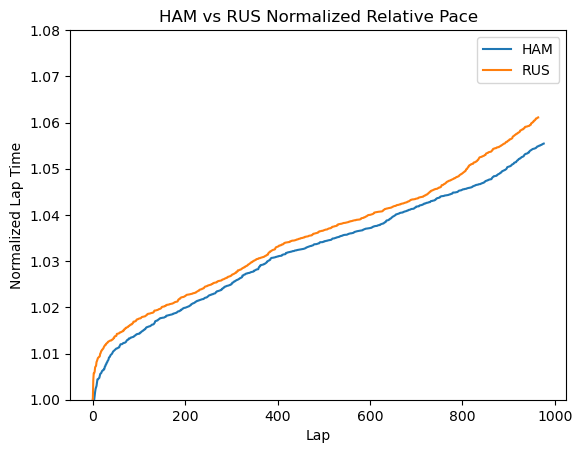

Area between VER and PER is 0.7167224686346864
Area between RUS and HAM is 0.29969116512923955
Area between SAI and LEC is 0.14511898078508292
Area between STR and ALO is 0.6656309490672012
Area between OCO and GAS is 0.5412453241087679
Area between NOR and PIA is 0.4290625011903582
Area between ALB and SAR is 0.39621623869040007
Area between BOT and ZHO is 0.20055416929644213
Area between HUL and MAG is 0.3633366114922035
Area between TSU and RIC is 1.0812937414606798


<Figure size 640x480 with 0 Axes>

In [29]:

import os 
def plot_normalized_drivers(df, driver1='PER', driver2='PER', driver3=None, save=False, show=True):
    '''
    Plot normalized lap times for 3 drivers
    '''
    driver1_norm = df[df[driver1] < df[driver1].quantile(.8)][driver1].sort_values().reset_index(drop=True)

    driver2_norm = df[df[driver2] < df[driver2].quantile(.8)][driver2].sort_values().reset_index(drop=True)

    norm = pd.DataFrame()
    norm[driver1] = driver1_norm
    norm[driver2] = driver2_norm
    
    if driver3:
        driver3_norm = df[df[driver3] < df[driver3].quantile(.8)][driver3].sort_values().reset_index(drop=True)
        norm[driver3] = driver3_norm

    fig = sns.lineplot(data=norm,dashes=False)
    fig.set(xlabel='Lap', ylabel='Normalized Lap Time')
    fig.set_title(f'{driver1} vs {driver2} Normalized Relative Pace')
    fig.set_ylim(1.0,1.08)
    
    length = min(len(driver1_norm), len(driver2_norm))
    
    area = abs(np.trapz(y=driver1_norm[:length] - driver2_norm[:length]))
    print(f"Area between {driver1} and {driver2} is {area*100/length}")

    if save:
        if not os.path.exists('./output/plots'):
            os.makedirs('./output/plots')
        fig.figure.savefig(f'./output/plots/{driver1}_{driver2}_norm.png', dpi=300)

    if show:
        plt.show()
    fig.figure.clf()
    
plot_normalized_drivers(allDriversNorm, driver1='HAM', driver2='RUS',save=True)



for t in teams.items():
    plot_normalized_drivers(allDriversNorm, driver1=t[1][0], driver2=t[1][1],save=True,show=False)


## Attempt to normalize by race 

In [16]:
drivers = {}

for k,r in allRaces.items():
    r['LapTime'] = r['LapTime']
    r['NormLapTime'] = r.LapTime/r.LapTime.min()
    for d in r.Driver.unique():
        drive = r[r.Driver == d]
        drive = drive[drive.NormLapTime < drive.NormLapTime.quantile(.8)].copy()
        
        try:
            drivers[d] = pd.concat([drivers[d], drive])
        except Exception as e:
            drivers[d] = drive
            
allDriversNorm2 = pd.DataFrame(columns=drivers.keys())
for k,v in drivers.items():
    allDriversNorm2[k] = pd.Series(v.NormLapTime.values)


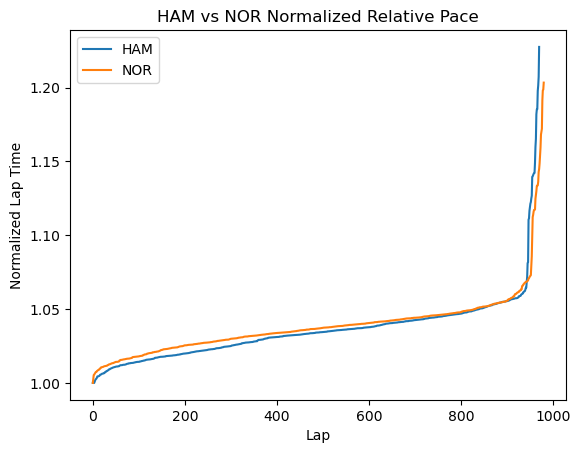

In [17]:


def plot_normalized_drivers_test(df, driver1='PER', driver2='PER', driver3=None):
    '''
    Plot normalized lap times for 3 drivers
    '''
    driver1_norm = df[driver1].sort_values().reset_index(drop=True)

    driver2_norm = df[driver2].sort_values().reset_index(drop=True)

    norm = pd.DataFrame()
    norm[driver1] = driver1_norm
    norm[driver2] = driver2_norm
    
    if driver3:
        driver3_norm = df[df[driver3] < df[driver3].quantile(.8)][driver3].sort_values().reset_index(drop=True)
        norm[driver3] = driver3_norm

    plt = sns.lineplot(data=norm,dashes=False)
    plt.set(xlabel='Lap', ylabel='Normalized Lap Time')
    plt.set_title(f'{driver1} vs {driver2} Normalized Relative Pace')

plot_normalized_drivers_test(allDriversNorm2, driver1='HAM', driver2='NOR')